Select the Activation Function to be implemented 
 1. Sigmoid 
 2. Tanh 
 3. ReLu
1
                      fixed acidity  volatile acidity  ...   alcohol   quality
fixed acidity              1.000000         -0.256131  ... -0.061668  0.124052
volatile acidity          -0.256131          1.000000  ... -0.202288 -0.390558
citric acid                0.671703         -0.552496  ...  0.109903  0.226373
residual sugar             0.114777          0.001918  ...  0.042075  0.013732
chlorides                  0.093705          0.061298  ... -0.221141 -0.128907
free sulfur dioxide       -0.153794         -0.010504  ... -0.069408 -0.050656
total sulfur dioxide      -0.113181          0.076470  ... -0.205654 -0.185100
density                    0.668047          0.022026  ... -0.496180 -0.174919
pH                        -0.682978          0.234937  ...  0.205633 -0.057731
sulphates                  0.183006         -0.260987  ...  0.093595  0.251397
alcohol                   -0.061668         -0.

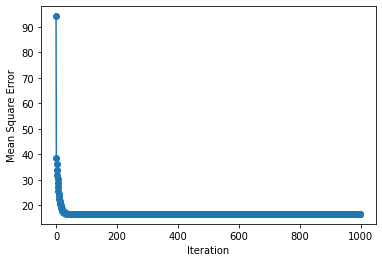

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import warnings
warnings.filterwarnings('ignore')

class NeuralNetwork:
    def __init__(self):
        np.random.seed(1)
        self.W1 = np.random.rand(8, 3)
        self.W2 = np.random.rand(4, 2)
        self.W3 = np.random.rand(3, 1)
        self.inputLayerNeurons  = 0

    def minMaxScaling(self, data):
        minX,maxX = np.min(data), np.max(data)
        difference = maxX - minX
        for index in range(data.shape[0]):
            data[index] = (data[index] - minX) / difference
        return data

    def meanScaling(self, data):
        meanArray = np.mean(data)
        sdArray = np.std(data)
        for index in range(data.shape[0]):
            data[index] = (data[index] - meanArray) / sdArray
        return data

    def sacleAndProcessData(self, data, featureLabels):
        for label in featureLabels:
            data[:, featureLabels[label]] = self.minMaxScaling(data[:, featureLabels[label]])
        return data

    def sigmoidActivationFunction(self, x):
        val = 1 / (1 + np.exp(-x, dtype=np.float64))
        val = np.minimum(val, 0.9999)
        val = np.maximum(val, 0.0001)
        return val

    def tahHActivationFunction(self, x):
        val = (2 * self.sigmoidActivationFunction(2 * x)) - 1
        return val

    def reluActivationFunction(self, x):
        return np.maximum(0, x)

    def forwardPass(self, X, activationFunction):
        layer1 = np.dot(X, self.W1)
        h = self.selectActivationFunction(activationFunction, layer1)
        layer1WithBias = np.insert(h, 0, 1, axis=1)
        layer2 = np.dot(layer1WithBias, self.W2)
        h = self.selectActivationFunction(activationFunction, layer2)
        layer2WithBias = np.insert(h, 0, 1, axis=1)
        layer3 = np.dot(layer2WithBias, self.W3)
        return layer1WithBias, layer2WithBias, self.selectActivationFunction(activationFunction, layer3)

    def selectActivationFunction(self, activationFunction, net):
        if activationFunction.lower() == "tanh".lower():
            return self.tahHActivationFunction(net)
        elif activationFunction.lower() == "ReLu".lower():
            return self.reluActivationFunction(net)
        else:
            return self.sigmoidActivationFunction(net)

    def calculateDelta(self, error, net, activationFunction):
        if activationFunction.lower() == "sigmoid".lower():
            return self.calculateDeltaForSigmoidFunction(error, net)
        elif activationFunction.lower() == "tanh".lower():
            return self.calculateDeltaForTanHFunction(error, net)
        elif activationFunction.lower() == "ReLu".lower():
            return self.calculateDeltaForReLuFunction(error, net)

    def calculateDeltaForSigmoidFunction(self, error, net):
        delta = np.multiply(np.multiply(net, (1 - net), dtype=np.float64), error)
        return delta

    def calculateDeltaForTanHFunction(self, error, net):
        delta = np.multiply(1 - np.square(net, dtype=np.float64), error)
        return delta

    def calculateDeltaForReLuFunction(self, error, net):
        return np.where(net <= 0, 0, error)

    def train(self, trainData, testData, epoch=1000, learningrate=0.00001, activationFunction='sigmoid',
              plotGraph=False):

        nrowsTrain, ncolsTrain = trainData.shape[0], trainData.shape[1]
        trainX = trainData[:, 0:(ncolsTrain - 1)]
        trainY = trainData[:, (ncolsTrain - 1)].reshape(nrowsTrain, 1)

        nrowsTest, ncolsTest = testData.shape[0], testData.shape[1]
        testX = testData[:, 0:(ncolsTest - 1)]
        testY = testData[:, (ncolsTest - 1)].reshape(nrowsTest, 1)

        mse = np.empty([1])
        iterations = np.empty([1])
        for count in range(epoch):
            layer1, layer2, predictTrain = self.forwardPass(trainX, activationFunction)
            error = trainY - predictTrain
            meanSquareError = 0.5 * np.dot(np.transpose(error), error)
            deltaOutputLayer = self.calculateDelta(error, predictTrain, activationFunction)
            delta1, delta2, delta3 = self.backwardPass(trainX, deltaOutputLayer, learningrate
                                                       , layer1, layer2, activationFunction)
            self.W1 = self.W1 + delta1
            self.W2 = self.W2 + delta2
            self.W3 = self.W3 + delta3
            mse = np.append(mse, meanSquareError)
            iterations = np.append(iterations, count)

        if plotGraph:
            iterations = np.delete(iterations, 0)
            mse = np.delete(mse, 0)
            plt.plot(iterations, mse, linestyle='-', marker='o')
            plt.xlabel("Iteration")
            plt.ylabel("Mean Square Error")
            plt.show()

        trainLayer1, trainLayer2, predictionTrain = self.forwardPass(trainX, activationFunction)
        trainError = trainY - predictionTrain
        meanSquareErrorTrain = 0.5 * np.dot(np.transpose(trainError), trainError)
        testLayer1, testLayer2, predictionTest = self.forwardPass(testX, activationFunction)
        test_error = testY - predictionTest
        meanSquareErrorTest = 0.5 * np.dot(np.transpose(test_error), test_error)
        #print("Mean Square Error Train : ", meanSquareErrorTrain, ", Mean Square Error Test : ",
             # meanSquareErrorTest)
        return meanSquareErrorTrain[0][0], meanSquareErrorTest[0][0]



    def backwardPass(self, X, deltaOutputLayer, learningrate, layer1, layer2, activationFunction):
        deltaW2 = np.dot(self.W3, deltaOutputLayer.T)
        deltaW2 = np.sum(deltaW2, axis=1).reshape(3, 1)
        netOutput = []
        if activationFunction.lower() == "sigmoid".lower():
            netOutput = np.sum(np.multiply(layer2, (1 - layer2), dtype=np.float64),
                               axis=0).reshape(3, 1)
        elif activationFunction.lower() == "tanh".lower():
            netOutput = np.sum((1 - np.square(layer2, dtype=np.float64)), axis=0).reshape(3, 1)
        elif activationFunction.lower() == "ReLu".lower():
            netOutput = np.sum(np.where(layer2 <= 0, 0, layer2), axis=0).reshape(3, 1)

        deltaLayer2 = np.multiply(netOutput, deltaW2, dtype=np.float64)
        deltsLayer2Temp = np.delete(deltaLayer2, (0), axis=0)
        deltaW1 = np.dot(self.W2, deltsLayer2Temp)
        netOutputTemp = []
        if activationFunction.lower() == "sigmoid".lower():
            netOutputTemp = np.sum(np.multiply(layer1, (1 - layer1), dtype=np.float64),
                                   axis=0).reshape(4, 1)
        elif activationFunction.lower() == "tanh".lower():
            netOutputTemp = np.sum((1 - np.square(layer1, dtype=np.float64)), axis=0).reshape(4, 1)
        elif activationFunction.lower() == "ReLu".lower():
            netOutputTemp = np.sum(np.where(layer1 <= 0, 0, layer1), axis=0).reshape(4, 1)

        deltaLayer1 = np.multiply(netOutputTemp, deltaW1, dtype=np.float64)
        deltaLayer1Temp = np.delete(deltaLayer1, (0), axis=0)
        layer2[:, 0] = np.multiply(layer2[:, 0].reshape(layer2.shape[0], 1),
                                   deltaOutputLayer).flatten()
        layer2[:, 1] = np.multiply(layer2[:, 1].reshape(layer2.shape[0], 1),
                                   deltaOutputLayer).flatten()
        layer2[:, 2] = np.multiply(layer2[:, 2].reshape(layer2.shape[0], 1),
                                   deltaOutputLayer).flatten()
        deltaW = layer2 * learningrate
        deltaW = np.sum(deltaW, axis=0).reshape(3, 1)
        layer1 = np.sum(layer1, axis=0).reshape(4, 1)
        netProaductDelta2 = np.dot(layer1, deltsLayer2Temp.T)
        deltaW2 = netProaductDelta2 * learningrate
        inputLayer = np.sum(X, axis=0).reshape(self.inputLayerNeurons , 1)
        netProductInputLayer = np.dot(inputLayer, deltaLayer1Temp.T)
        deltaW1 = netProductInputLayer * learningrate
        return deltaW1, deltaW2, deltaW


if __name__ == "__main__":
    print("Select the Activation Function to be implemented \n 1. Sigmoid \n 2. Tanh \n 3. ReLu")
    inp = int(input())
    if inp == 1:
        activationFunction = "sigmoid"
    elif inp == 2:
        activationFunction = "tanh"
    else:
        activationFunction = "relu"
    datasetURL ='https://cs6375assignments.s3.amazonaws.com/assignments/Assignment-2/winequality-red.csv'
    plotGraph = True
    df = pd.read_csv(datasetURL, ';')
    correlations = df.corr()
    print(correlations)
    # f = plt.figure(figsize=(19, 15))
    # plt.matshow(correlations, fignum=f.number)
    # plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
    # plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
    # cb = plt.colorbar()  
    # cb.ax.tick_params(labelsize=14)
    # plt.title('Correlation Matrix', fontsize=16);   
    cols = df.columns
    columnsToBeRemovedSet = set([])
    for i in range(0, correlations.shape[0]):
        for j in range(0, correlations.shape[1]):
          if (float(correlations.iloc[i][j]) > 0.7 or float(correlations.iloc[i][j]) < -0.7) and i != j:
            print(cols[i], " | ", cols[j], " \t | ", correlations.iloc[i][j])
    columnsToDrop = ['citric acid','free sulfur dioxide','fixed acidity']
    print("Dropping Unwanted Columns : ")
    print(columnsToDrop)
    df = df.drop(columns=columnsToDrop)
    featureLabels = {}
    columns = df.columns
    for i in range(len(columns)):
        featureLabels[columns[i]] = i
    print("Feature Labels --> ", featureLabels)
    data = df.iloc[:, :].values.reshape(df.shape[0], df.shape[1])
    myNeuralNetwork = NeuralNetwork()
    myNeuralNetwork.inputLayerNeurons = len(featureLabels)-1
    myNeuralNetwork.W1 = np.random.rand(myNeuralNetwork.inputLayerNeurons, 3)
    data = myNeuralNetwork.sacleAndProcessData(data, featureLabels)
    indices = np.random.permutation(data.shape[0])
    trainingIndices, testIndices = indices[:int((data.shape[0] * 0.8))], indices[int((data.shape[0] * 0.8)):]
    trainingData, testData = data[trainingIndices, :], data[testIndices, :]
    epoch = 1000
    lr = 0.001
    globalW1 = myNeuralNetwork.W1
    globalW2 = myNeuralNetwork.W2
    globalW3 = myNeuralNetwork.W3
    meanSquareErrorTrain, meanSquareErrorTest=myNeuralNetwork.train(trainingData,testData,epoch, lr,activationFunction,plotGraph)

    #Driver Code to find Observations:

    # epochList = [1,19,57,175,553,999,5043,9999]
    # lrList =[0.01,0.001,0.003,0.006,0.009,0.0001,0.0004,0.0007]
    # count = 1
    # results=[]
    # for activationFunction in ["sigmoid", "tanh", "relu"]:
    #     for epoch in epochList:
    #         for lr in lrList:
    #             meanSquareErrorTrain, meanSquareErrorTest=myNeuralNetwork.train(trainingData,testData,epoch, lr,activationFunction,False)
    #             row={}
    #             row["SNo."]=count
    #             row["Activation Function"]=activationFunction
    #             row["Epoch"]=epoch
    #             row["Learning Rate"]=lr
    #             row["Mean Square Error Train"]=meanSquareErrorTrain
    #             row["Mean Square Error Test"]=meanSquareErrorTest
    #             row["Difference"] = meanSquareErrorTrain-meanSquareErrorTest
    #             results.append(row)
    #             count+=1
    # df = pd.DataFrame(results)
    # df.to_excel("observations.xlsx")